# ERA5 RAPID-OSNAP in TS space

In [51]:
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import cmocean
import gsw
import os
import pickle
from matplotlib import cm

import seawater as sw
import scipy.stats as sp_stat
import matplotlib.dates as mdates
import datetime
import cftime
from scipy import interpolate
from scipy.interpolate import interp2d

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import griddata

In [52]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Load ERA5 surface flux data

In [53]:
fname = '/Users/dgwynevans/Dropbox/work_general/datasets/ERA5/ERA5_surfaceflux.nc'
era5_dset = xr.open_dataset(fname)

# lon_limits = [20, 275]
# lon_limits = [275, 355]
# lat_limits = [25, 60]
lon_limits = [250, 360]
lat_limits = [25, 65]

era5_dset = era5_dset.sel(latitude = era5_dset.latitude>=lat_limits[0])
# era5_dset = era5_dset.sel(longitude=((era5_dset.longitude<lon_limits[0]) | (era5_dset.longitude>lon_limits[1])), latitude=((era5_dset.latitude>lat_limits[0]) & (era5_dset.latitude<lat_limits[1])))
# era5_dset = era5_dset.sel(longitude=((era5_dset.longitude>lon_limits[0]) & (era5_dset.longitude<lon_limits[1])), latitude=((era5_dset.latitude>lat_limits[0]) & (era5_dset.latitude<lat_limits[1])))
qnet = (era5_dset.ssr + era5_dset.str + era5_dset.slhf + era5_dset.sshf) / (24*60*60) # Convert to W m^-2
fnet = (np.abs(era5_dset.e) - era5_dset.tp) / (24*60*60) # Convert to m s^-1

In [54]:
mask_dir = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
mask = xr.open_dataset(mask_dir)

# mask_nan = mask.basin.data
# mask_nan[mask_nan < 0] = np.nan

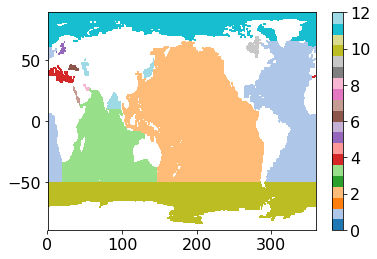

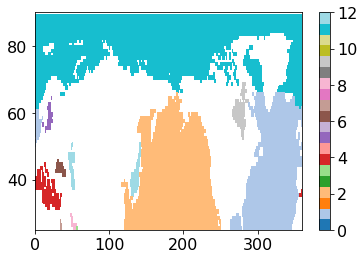

In [55]:
fig, ax = plt.subplots()
CS = ax.pcolormesh(mask.X, mask.Y, mask.basin[0, :, :], vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

lon_g, lat_g = np.meshgrid(era5_dset.longitude.data, era5_dset.latitude.data)

interp_points = np.array([lat_g.flatten(), lon_g.flatten()]).T
f = rgi((mask.Y.data, mask.X.data), mask.basin.data[0, :, :], method='nearest', bounds_error=False)
maski = f(interp_points)
maski = np.reshape(maski, (len(era5_dset.latitude.data), len(era5_dset.longitude.data)))
# maski = np.moveaxis(np.expand_dims(maski, axis=3), [0, 1, 2], [1, 2, 0])
# maski = np.moveaxis(maski, [0, 1], [1, 0])

fig, ax = plt.subplots()
CS = ax.pcolormesh(era5_dset.longitude, era5_dset.latitude, maski, vmin=0, vmax=12, cmap=cm.tab20)
cbar = fig.colorbar(CS, ax=ax)

In [56]:
sst = era5_dset.sst.data[0, :, :]
lon_g_mask, lat_g_mask = np.meshgrid(mask.X.data, mask.Y.data)
lon_g_en4, lat_g_en4 = np.meshgrid(era5_dset.longitude.data, era5_dset.latitude.data)

mask_filled = maski.copy()

masknan_idx = ~np.isnan(mask.basin.data[0, :, :])
nomask_idx = ~np.isnan(sst) & np.isnan(maski)

interp_points = np.array([lat_g_en4[nomask_idx], lon_g_en4[nomask_idx]]).T
nomask_int = griddata((lat_g_mask[masknan_idx], lon_g_mask[masknan_idx]), mask.basin.data[0, :, :][masknan_idx], interp_points, method='nearest')

mask_filled[nomask_idx] = nomask_int.copy()

Text(0,0.5,'F$_{net}$ [m s$^{-1}$]')

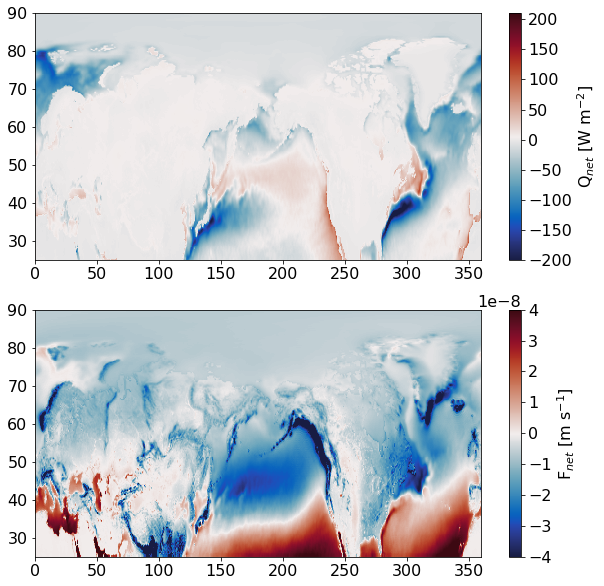

In [59]:
fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

qnet_levels = (-200, 210)
fnet_levels = (-4e-8, 4e-8) 

CS_T = ax1.pcolormesh(era5_dset.longitude, era5_dset.latitude, np.nanmean(qnet, axis=0),
           cmap=cmocean.cm.balance, vmin=qnet_levels[0], vmax=qnet_levels[1])

CS_S = ax2.pcolormesh(era5_dset.longitude, era5_dset.latitude, np.nanmean(fnet, axis=0), 
                    cmap=cmocean.cm.balance, vmin=fnet_levels[0], vmax=fnet_levels[1])

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Q$_{net}$ [W m$^{-2}$]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('F$_{net}$ [m s$^{-1}$]')

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


Text(0,0.5,'F$_{net}$ [m s$^{-1}$]')

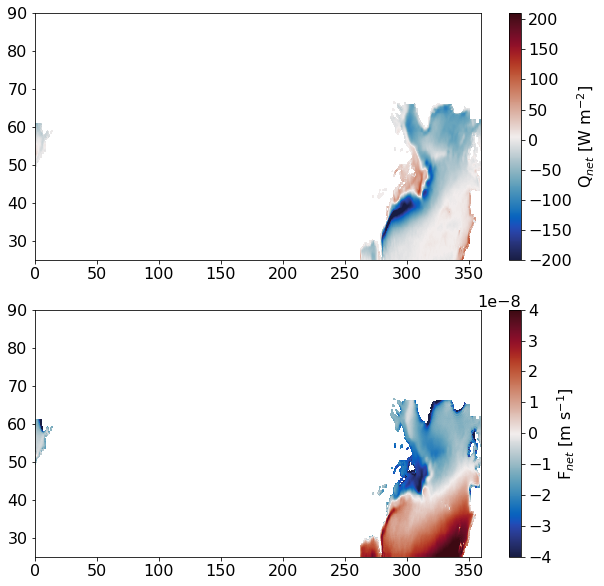

In [58]:
qnet_nan = np.moveaxis(qnet.data.copy(), 0, -1)
qnet_nan[mask_filled != 1] = np.nan

fnet_nan = np.moveaxis(fnet.data.copy(), 0, -1)
fnet_nan[mask_filled != 1] = np.nan

fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

qnet_levels = (-200, 210)
fnet_levels = (-4e-8, 4e-8) 

CS_T = ax1.pcolormesh(era5_dset.longitude, era5_dset.latitude, np.nanmean(qnet_nan, axis=2),
           cmap=cmocean.cm.balance, vmin=qnet_levels[0], vmax=qnet_levels[1])

CS_S = ax2.pcolormesh(era5_dset.longitude, era5_dset.latitude, np.nanmean(fnet_nan, axis=2), 
                    cmap=cmocean.cm.balance, vmin=fnet_levels[0], vmax=fnet_levels[1])

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Q$_{net}$ [W m$^{-2}$]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('F$_{net}$ [m s$^{-1}$]')

### Load CMEMS SSS

In [75]:
dset_dir = '/Users/dgwynevans/Dropbox/work_general/datasets/CMEMS_SSS_SSD/*.nc'
SSS_dset = xr.open_mfdataset(dset_dir)

# SSS_dset = SSS_dset.sel(lon=((SSS_dset.lon<lon_limits[0]) | (SSS_dset.lon>lon_limits[1])), lat=slice(lat_limits[0],lat_limits[1]))
# SSS_dset = SSS_dset.sel(lon=((SSS_dset.lon>lon_limits[0]) & (SSS_dset.lon<lon_limits[1])), lat=slice(lat_limits[0],lat_limits[1]))
SSS_dset = SSS_dset.sel(lat=SSS_dset.lat>lat_limits[0])

### Select only dates after 2004 and up to the end of 2018

In [76]:
sss_dats = cftime.date2num(SSS_dset.time.data, 'days since 0001-01-01 UTC', calendar='gregorian') - 1
era5_dats = mdates.date2num(era5_dset.time) + 14

dat_lim = (mdates.date2num(datetime.datetime(2000, 1, 1)),
           mdates.date2num(datetime.datetime(2019, 1, 1)))

era5_idx = (era5_dats > dat_lim[0]) & (era5_dats < dat_lim[1])
sss_idx = (sss_dats > dat_lim[0]) & (sss_dats < dat_lim[1])

qnet_argo = qnet[era5_idx, :, :]
fnet_argo = fnet[era5_idx, :, :]
sst_argo = era5_dset.sst[era5_idx, :, :] - 273.15
sss_argo = SSS_dset.sos[sss_idx]

dats = sss_dats[sss_idx]

In [77]:
sssi = np.zeros((len(dats), len(era5_dset.latitude), len(era5_dset.longitude)))


for ii in np.arange(0, len(dats), 1):
    
    sss_slice = sss_argo[ii, 0, :, :].compute().data
    sss_slice[np.isnan(sss_slice)] = 0    
    
    f = interpolate.interp2d(SSS_dset.lon.data, SSS_dset.lat.data, np.flipud(sss_slice), kind='linear', fill_value=np.nan)
    sssi[ii, :, :] = f(era5_dset.longitude.data, era5_dset.latitude.data) 
    

In [78]:
qnet_argo = np.moveaxis(qnet_argo.data, 0, -1)
fnet_argo = np.moveaxis(fnet_argo.data, 0, -1)
sst_argo = np.moveaxis(sst_argo.data, 0, -1)
sssi = np.moveaxis(sssi, 0, -1)

sst_argo[mask_filled != 1] = np.nan
sssi[mask_filled != 1] = np.nan

In [63]:
dlat = np.diff(era5_dset.latitude).mean()
dlon = np.diff(era5_dset.longitude).mean()

dx = np.repeat(gsw.distance(np.hstack( (np.zeros((len(era5_dset.latitude), 1)), np.ones((len(era5_dset.latitude), 1))*dlon )),
                 np.hstack( (np.expand_dims(era5_dset.latitude, axis=1), np.expand_dims(era5_dset.latitude, axis=1) ) ) ),
               len(era5_dset.longitude), axis=1)

dy = np.repeat(gsw.distance(np.hstack( (np.expand_dims(era5_dset.longitude, axis=1), np.expand_dims(era5_dset.longitude, axis=1)) ), 
                 np.hstack( (np.zeros((len(era5_dset.longitude), 1)), np.ones((len(era5_dset.longitude), 1))*dlat) ) ),
              len(era5_dset.latitude), axis=1)
dy = np.transpose(dy)

gr_area = dx * dy

In [85]:
type(sssi)

numpy.ndarray

### Now bin into TS space to calculate transformations

In [86]:
dS = 0.025
dT = 0.25
S_bin = np.arange(25, 40 + dS, dS)
T_bin = np.arange(-3, 32 + dT, dT)
# S_bin = np.arange(32, 38 + dS, dS)
# T_bin = np.arange(-3, 32 + dT, dT)
S_bini = S_bin[0:-1] + dS/2
T_bini = T_bin[0:-1] + dT/2 
S_binj = np.arange(S_bin[0] - dS/2, S_bin[-1] + dS, dS)
T_binj = np.arange(T_bin[0] - dT/2, T_bin[-1] + dT, dT)

S_gridt, T_gridt = np.meshgrid(S_bini, T_bin)
S_grids, T_grids = np.meshgrid(S_bin, T_bini)

cp = gsw.cp_t_exact(S_gridt, T_gridt, 0)
dens = sw.dens0(S_gridt, T_gridt)

T_const = np.expand_dims(cp * dens * dT, axis=2)
S_const = np.expand_dims(S_grids / dS, axis=2)

E_t = np.zeros((len(T_bin), len(S_bini), len(dats)))
E_s = np.zeros((len(T_bini), len(S_bin), len(dats)))

for ii in np.arange(0, len(dats), 1):
    # Dia-thermal transformations 
    bin_edge1 = T_binj
    bin_edge2 = S_bin

    bin1 = sst_argo[:, :, ii].flatten()
    bin2 = sssi[:, :, ii].flatten()
    var = (qnet_argo[:, :, ii] * gr_area).flatten()

    out = sp_stat.binned_statistic_2d(bin1, bin2, var, statistic='sum', bins=(bin_edge1, bin_edge2))

    E_t[:, :, ii] = out[0].copy()

    # Dia-haline transformations 
    bin_edge1 = T_bin
    bin_edge2 = S_binj

    var = (fnet_argo[:, :, ii] * gr_area).flatten()

    out = sp_stat.binned_statistic_2d(bin1, bin2, var, statistic='sum', bins=(bin_edge1, bin_edge2))

    E_s[:, :, ii] = out[0].copy()

E_t = E_t / T_const
E_s = E_s * S_const

E_ti = np.zeros((len(T_bini),len(S_bini), len(dats)))
E_si = np.zeros((len(T_bini),len(S_bini), len(dats)))

for ii in np.arange(0, len(dats), 1):
    f = interp2d(S_bini, T_bin, E_t[:, :, ii], kind='linear', fill_value=np.nan)
    E_ti[:, :, ii] = f(S_bini, T_bini) 

    f = interp2d(S_bin, T_bini, E_s[:, :, ii], kind='linear', fill_value=np.nan)
    E_si[:, :, ii] = f(S_bini, T_bini) 

surf_trans = {'E_t': E_t, 'E_s': E_s, 'E_ti': E_ti, 'E_si': E_si, 'time': dats}

### Save using pickle

To load use the following: </br>

```python
with open(fname, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ts_vol = pickle.load(f)
```

In [90]:
outfile = '~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/ERA5_TS_dS_{:2.3f}_dT_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(dS, dT, lat_limits[0], lat_limits[1])

with open(os.path.expanduser(outfile), 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(surf_trans, f, pickle.HIGHEST_PROTOCOL)

In [87]:
def dateticker(ax):
    loc = mdates.AutoDateLocator()
    tick_format = mdates.AutoDateFormatter(loc)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(tick_format)

Text(0,0.5,'SA [g/kg]')

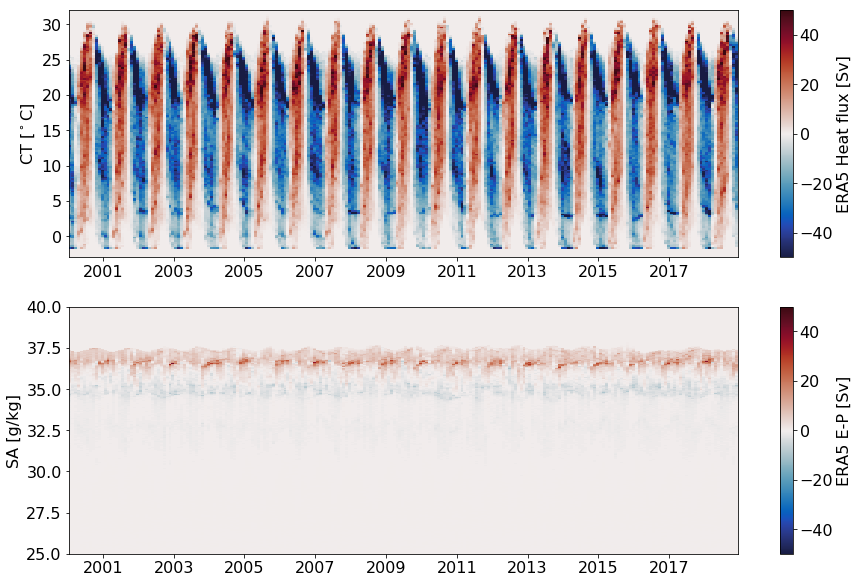

In [88]:
E_t_time_anom_t = np.nansum(E_t - np.expand_dims(np.nanmean(E_t, axis=2), axis=2), axis=1)
E_s_time_anom_s = np.nansum(E_s - np.expand_dims(np.nanmean(E_s, axis=2), axis=2), axis=0)

E_t_t = np.nansum(E_t, axis=1)
E_s_s = np.nansum(E_s, axis=0)

fig = plt.figure(figsize=(15,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]

trans_lim = (-50, 50)
cs_t = ax1.pcolormesh(dats, T_bin, E_t_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(dats, S_bin, E_s_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('ERA5 Heat flux [Sv]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('ERA5 E-P [Sv]')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')


In [41]:
datvec = np.zeros((len(dats), 3))
for ii in np.arange(0, len(dats), 1):
    datvec[ii, 0] = mdates.num2date(dats)[ii].year
    datvec[ii, 1] = mdates.num2date(dats)[ii].month
    datvec[ii, 2] = mdates.num2date(dats)[ii].day
    
E_t_mm = np.zeros((np.shape(E_t)[0], np.shape(E_t)[1], 12))
E_s_mm = np.zeros((np.shape(E_s)[0], np.shape(E_s)[1], 12))
E_t_mm_an = np.zeros(np.shape(E_t))
E_s_mm_an = np.zeros(np.shape(E_s))

for ii in np.arange(1, 13, 1):
    E_t_mm[:, :, ii - 1] = np.nanmean(E_t[:, :, datvec[:, 1] == ii], axis=2)
    E_s_mm[:, :, ii - 1] = np.nanmean(E_s[:, :, datvec[:, 1] == ii], axis=2)
    
    E_t_mm_an[:, :, datvec[:, 1] == ii] = E_t[:, :, datvec[:, 1] == ii] - np.expand_dims(E_t_mm[:, :, ii - 1], axis=2)    
    E_s_mm_an[:, :, datvec[:, 1] == ii] = E_s[:, :, datvec[:, 1] == ii] - np.expand_dims(E_s_mm[:, :, ii - 1], axis=2)

Text(0,0.5,'SA [g/kg]')

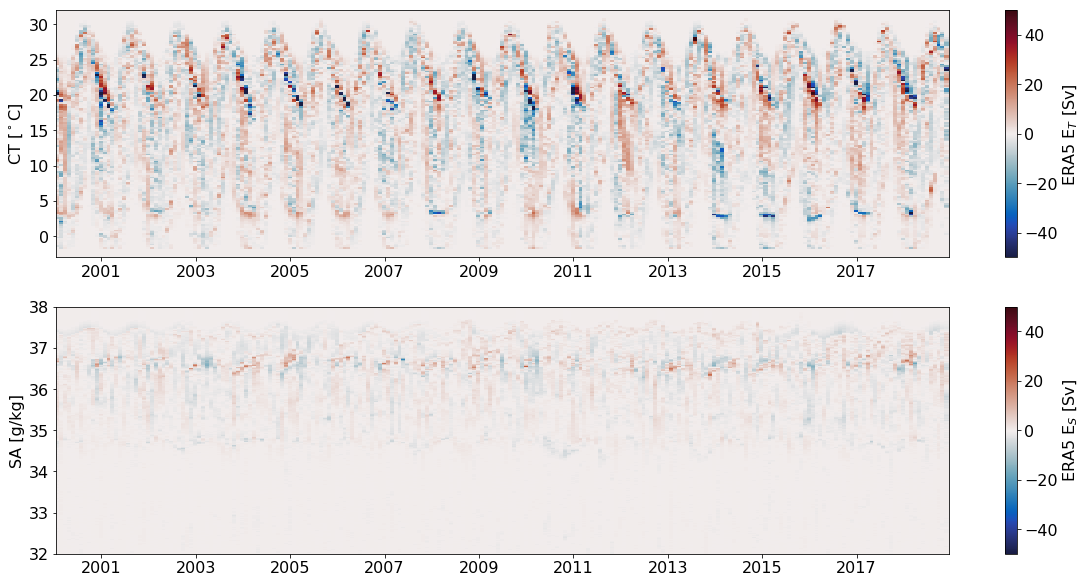

In [45]:
E_t_mm_an_t = np.nansum(E_t_mm_an, axis=1)
E_s_mm_an_s = np.nansum(E_s_mm_an, axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]

trans_lim = (-50, 50)
cs_t = ax1.pcolormesh(dats, T_bin, E_t_mm_an_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(dats, S_bin, E_s_mm_an_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('ERA5 E$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('ERA5 E$_S$ [Sv]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

In [29]:
np.shape(E_s)

(70, 121, 228)

In [34]:
np.shape(S_bin)

(121,)

In [36]:
np.shape(T_bini)

(70,)